# **Baseline Model: Predicting Mental Rotation Accuracy**

### **Objective**
We build a **baseline model** to predict whether a participant's response is **Correct (1) or Incorrect (0)** using multimodal data:
- **EEG**: Brainwave features (Delta, Theta, Alpha, Beta, Gamma)
- **Eye-tracking**: Pupil size, fixation duration, saccade amplitude, counts
- **GSR**: Skin conductance statistics
- **Facial expressions**: Emotion scores and Action Units (AU)

**Purpose of baseline model:**
1. Establish an initial benchmark performance.
2. Check which features/modalities are most useful.
3. Validate preprocessing and feature engineering.

---

### Target and Features
- **Target (`y`)**: `Result` column from `PSY.csv`  
  - Correct → 1  
  - Incorrect → 0  
- **Features (`X`)**: Aggregated features from all modalities.  
- Trials with no responses are **kept as NaN** to preserve temporal structure.

---

### Train-Test Split
- Use **stratified split** to maintain class balance.
- Typical split: **80% training, 20% testing**.

---

### Baseline Models
- **Logistic Regression** – interpretable linear model.
- **Random Forest** – robust ensemble tree-based model.
- **XGBoost** – gradient boosting for structured/tabular data.

> These models provide an initial performance benchmark before using advanced fusion or deep learning.

---

### Evaluation Metrics
- **Accuracy** – overall correctness of predictions
- **F1-score** – balance between precision and recall
- **Precision & Recall** – class-specific performance
- **ROC-AUC** – model's probability discrimination
- **Confusion Matrix** – visual summary of predictions

---

### Visualization & Importance
- Confusion matrix and ROC curve visualize model performance.
- Feature importance shows which modalities and features contribute most.


In [3]:
!pip install imbalanced-learn matplotlib seaborn scikit-learn pandas pickle5 lime
!pip install optuna

  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pickle5
  Running setup.py clean for pickle5
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9c677b036813a66d7cc48f1db4b6d534a805b6ca3a3ee6a7d9f14f62724cf815
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
Failed to build pickle5
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pickle5)


# **Importing Essential Libraries**

We import the necessary libraries for **data handling, preprocessing, modeling, evaluation, and interpretability**:

- **Data & Visualization:** `pandas`, `numpy`, `matplotlib`, `seaborn`, `random`
- **Preprocessing & Encoding:** `StandardScaler`, `LabelEncoder`
- **Modeling:** `RandomForestClassifier`, `LogisticRegression`, `XGBClassifier`
- **Resampling:** `SMOTE` (to handle class imbalance)
- **Model Evaluation:** `accuracy_score`, `f1_score`, `roc_auc_score`, `confusion_matrix`, `classification_report`
- **Model Saving:** `pickle`
- **Hyperparameter Tuning:** `optuna`
- **Interpretability:** `shap`, `LimeTabularExplainer`

> These imports provide all the tools needed to build, evaluate, and explain our baseline models for predicting mental rotation task correctness.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import optuna
import shap
from lime.lime_tabular import LimeTabularExplainer

In [7]:
# Path to merged dataset
DATA_PATH = "/content/drive/MyDrive/IITBinternship/FinalFeatureEngineering/CompleteFeatureEngineering.csv"
df = pd.read_csv(DATA_PATH)

# Quick info
print("Data loaded")
print(df.shape)
display(df.head())
df.info()


Data loaded
(1572, 57)


,Key,Participant_ID,Category,Difficulty,ResponseTime,routineStart,routineEnd,Start_ms,End_ms,eeg_mean_delta,...,tiva_max_valence,tiva_mean_confusion,tiva_max_confusion,tiva_mean_neutral,tiva_max_neutral,tiva_mean_attention,tiva_max_attention,tiva_mean_blinkrate,tiva_max_blinkrate,Result
0,1spl1,1,1,0,10.369816,1.680003e+09,1.680003e+09,1.680003e+12,1.680003e+12,0.278648,...,0.0,0.001485,0.006085,99.600280,99.618683,97.983404,98.754173,0.000000,0.0,1.0
1,1spl2,1,1,0,7.913991,1.680003e+09,1.680003e+09,1.680003e+12,1.680003e+12,0.709148,...,0.0,0.001340,0.006678,99.616922,99.633865,97.835235,98.224716,0.000000,0.0,1.0
2,1Item1,1,1,0,7.654472,1.680003e+09,1.680003e+09,1.680003e+12,1.680003e+12,0.854009,...,0.0,0.002007,0.011253,99.596406,99.637833,97.571289,98.103561,0.000000,0.0,1.0
3,1Item2,1,1,0,14.597205,1.680003e+09,1.680003e+09,1.680003e+12,1.680003e+12,0.838483,...,0.0,0.001570,0.003732,99.617223,99.628273,97.176145,97.936546,0.000000,0.0,1.0
4,1Item3,1,1,0,16.476565,1.680003e+09,1.680003e+09,1.680003e+12,1.680003e+12,0.794340,...,0.0,0.001822,0.006987,99.616666,99.633286,96.939123,97.773972,0.689189,6.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Key                   1572 non-null   object 
 1   Participant_ID        1572 non-null   int64  
 2   Category              1572 non-null   int64  
 3   Difficulty            1572 non-null   int64  
 4   ResponseTime          1572 non-null   float64
 5   routineStart          1572 non-null   float64
 6   routineEnd            1572 non-null   float64
 7   Start_ms              1572 non-null   float64
 8   End_ms                1572 non-null   float64
 9   eeg_mean_delta        1572 non-null   float64
 10  eeg_mean_theta        1572 non-null   float64
 11  eeg_mean_alpha        1572 non-null   float64
 12  eeg_mean_beta         1572 non-null   float64
 13  eeg_mean_gamma        1572 non-null   float64
 14  eeg_std_theta         1572 non-null   float64
 15  eeg_std_alpha        

# Target Distribution Analysis

We first examine the **target variable (`Result`)** which indicates whether a participant's response is correct (`1`) or incorrect (`0`).  

- **Count and proportion:** Helps understand the class balance and detect potential imbalance issues.  
- **Visualization:** A simple count plot shows the distribution of correct vs incorrect responses across all trials.  

> Understanding the target distribution is crucial before building any classification model, as class imbalance can affect model performance.


✅ Sample counts based on Result:
 Result
1.0    1103
0.0     332
NaN     137
Name: count, dtype: int64

✅ Sample percentage based on Result:
 Result
1.0    70.165394
0.0    21.119593
NaN     8.715013
Name: proportion, dtype: float64


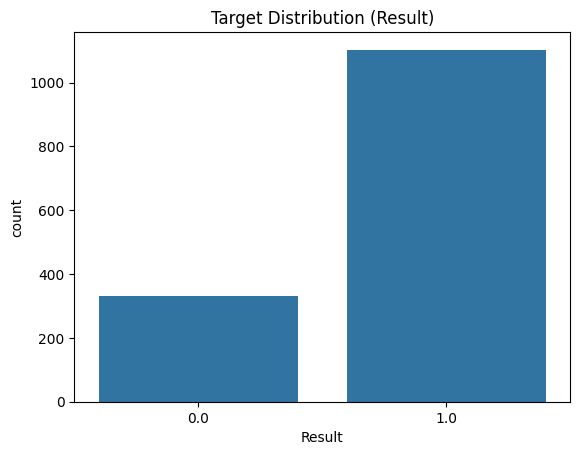

In [8]:
# Count and proportion
counts = df['Result'].value_counts(dropna=False)
percent = df['Result'].value_counts(normalize=True, dropna=False) * 100
print("✅ Sample counts based on Result:\n", counts)
print("\n✅ Sample percentage based on Result:\n", percent)

# Visualize target distribution
sns.countplot(x='Result', data=df)
plt.title("Target Distribution (Result)")
plt.show()


# Removing Trials with Missing Target

Some trials have missing `Result` values (i.e., no participant response).  
- We **drop rows where `Result` is NaN** to ensure the model only trains on trials with known outcomes.  
- Keeping NaNs would confuse the classifier since it cannot learn from undefined labels.

In [9]:
df = df.dropna(subset=['Result'])

# Feature Selection and Scaling

1. **Separating Features and Target**  
   - `X` → All input features from EEG, Eye-tracking, GSR, and Facial data.  
   - `y` → Target variable (`Result`: Correct=1, Incorrect=0).  
   - Columns like `Key`, `Participant_ID`, and timestamps are dropped since they are **identifiers**, not predictive features.

2. **Feature Scaling**  
   - StandardScaler is applied to normalize features (mean=0, std=1).  
   - Scaling is necessary because some algorithms (like Logistic Regression) are sensitive to feature magnitude differences.

> This ensures all modalities contribute fairly and improves model convergence and performance.


In [10]:
X = df.drop(columns=['Result','Key','Participant_ID','Start_ms','End_ms','routineStart','routineEnd'])
y = df['Result']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Handling Class Imbalance with SMOTE

1. **Problem**:  
   - In our dataset, the number of `Correct` vs `Incorrect` responses may be imbalanced.  
   - Imbalanced classes can bias models toward the majority class.

2. **Solution**: **SMOTE (Synthetic Minority Over-sampling Technique)**  
   - Generates synthetic samples for the minority class to balance the dataset.  
   - Ensures models learn patterns from both classes equally.

3. **Post-SMOTE Check**:  
   - The class distribution is now balanced, as visualized with a count plot.  

> Balanced dataset improves the fairness and performance of binary classification models.


After SMOTE class distribution:
Result
1.0    1103
0.0    1103
Name: count, dtype: int64


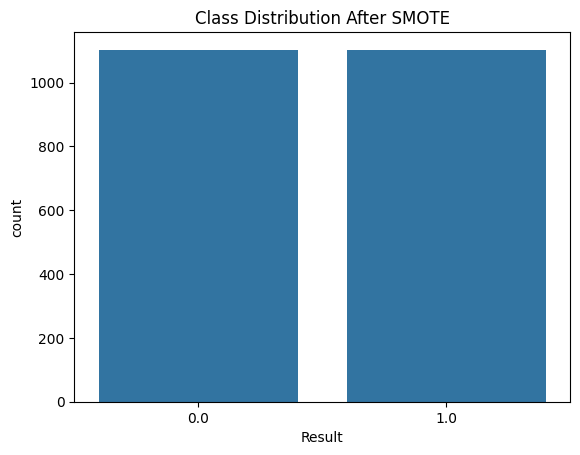

In [11]:
# Balance Dataset using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("After SMOTE class distribution:")
print(pd.Series(y_res).value_counts())

sns.countplot(x=y_res)
plt.title("Class Distribution After SMOTE")
plt.show()

In [12]:
# Train/Test Split
# We split the dataset into 80% training and 20% testing to evaluate the model on unseen data, using stratification to maintain the same class distribution in both sets.

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Random Forest Hyperparameter Tuning using Optuna

In this step, we optimize the Random Forest model for our binary classification task (predicting mental rotation correctness).

- **Purpose:** Improve model performance by automatically selecting the best combination of hyperparameters instead of relying on defaults.
- **Hyperparameters tuned:**
  - `n_estimators` → Number of trees in the forest.
  - `max_depth` → Maximum depth of each tree (controls overfitting).
  - `min_samples_split` → Minimum samples required to split a node.
  - `min_samples_leaf` → Minimum samples required at a leaf node.
- **Evaluation metric:** F1-score on the test set (balances precision & recall for our imbalanced classes).
- **Process:** Optuna runs multiple trials, each testing a different combination of hyperparameters, and selects the one with the highest F1-score.


In [13]:
# Hyperparameter Tuning with Optuna
# Random Forest Objective
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return f1_score(y_test, y_pred)


In [14]:
rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=30)

[I 2025-09-27 13:21:53,018] A new study created in memory with name: no-name-0eb12868-9db3-479e-8c27-fe5c12b4832b
[I 2025-09-27 13:21:54,040] Trial 0 finished with value: 0.8215158924205379 and parameters: {'n_estimators': 55, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8215158924205379.
[I 2025-09-27 13:21:58,419] Trial 1 finished with value: 0.8086124401913876 and parameters: {'n_estimators': 179, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8215158924205379.
[I 2025-09-27 13:22:01,048] Trial 2 finished with value: 0.8345323741007195 and parameters: {'n_estimators': 85, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8345323741007195.
[I 2025-09-27 13:22:07,062] Trial 3 finished with value: 0.8049382716049382 and parameters: {'n_estimators': 240, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.

In [17]:
# Print best trial
print("Number of finished trials: ", len(rf_study.trials))
print("Best trial:")
best_trial = rf_study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


Number of finished trials:  30
Best trial:
  Value:  0.8524590163934426
  Params: 
    n_estimators: 201
    max_depth: 17
    min_samples_split: 10
    min_samples_leaf: 1


# XGBoost Hyperparameter Optimization with Optuna

In this step, we optimize the XGBoost model's hyperparameters using Optuna.

- **Parameters being tuned:**
  - `n_estimators` → Number of trees in the ensemble.
  - `max_depth` → Maximum depth of each tree to control overfitting.
  - `learning_rate` → Step size shrinkage for boosting.
  - `subsample` → Fraction of samples used per tree for robustness.
  - `colsample_bytree` → Fraction of features used per tree.
- **`use_label_encoder=False`** → Avoids deprecated label encoding warning.
- **`eval_metric="logloss"`** → Optimizes the model for classification probability.
- **Objective:** Maximize F1-score on the test set to handle class imbalance.
- **Importance:** Automated tuning ensures the best XGBoost model configuration for predicting correct vs incorrect responses.


In [15]:
# XGBoost Objective
def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "random_state": 42
    }
    xgb = XGBClassifier(**params)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    return f1_score(y_test, y_pred)

In [16]:
xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=30)

[I 2025-09-27 13:24:10,827] A new study created in memory with name: no-name-211a4996-8000-4ea0-b00a-821f8de9db22
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:24:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-27 13:24:11,240] Trial 0 finished with value: 0.8325581395348837 and parameters: {'n_estimators': 88, 'max_depth': 4, 'learning_rate': 0.2067618837652228, 'subsample': 0.8676225473396079, 'colsample_bytree': 0.7667371174126443}. Best is trial 0 with value: 0.8325581395348837.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:24:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-27 13:24:14,017] Trial 1 finished with value: 0.8584474885844748 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0

In [18]:
# Print best trial for XGBoost
print("Number of finished trials: ", len(xgb_study.trials))
print("Best trial:")
best_trial = xgb_study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


Number of finished trials:  30
Best trial:
  Value:  0.8747152619589977
  Params: 
    n_estimators: 210
    max_depth: 10
    learning_rate: 0.23631906781399917
    subsample: 0.5274340483610269
    colsample_bytree: 0.5029634929177713


# Logistic Regression Hyperparameter Tuning with Optuna

Here, we optimize the Logistic Regression model to predict mental rotation accuracy.

- **Parameters being tuned:**
  - `C` → Inverse of regularization strength; controls overfitting. Log scale search allows exploring small and large values.
  - `solver` → Algorithm to optimize the logistic loss (`lbfgs` or `liblinear`).
- **`max_iter=5000`** → Ensures convergence during training.
- **Objective:** Maximize F1-score on the test set to effectively handle class imbalance.
- **Importance:** Fine-tuning improves baseline linear model performance and provides a simple interpretable benchmark for more complex models like Random Forest or XGBoost.


In [19]:
# Logistic Regression Objective
def lr_objective(trial):
    C = trial.suggest_float("C", 0.01, 10.0, log=True)
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
    lr = LogisticRegression(C=C, solver=solver, max_iter=5000, random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return f1_score(y_test, y_pred)


In [20]:
lr_study = optuna.create_study(direction="maximize")
lr_study.optimize(lr_objective, n_trials=30)

[I 2025-09-27 13:27:07,421] A new study created in memory with name: no-name-08539a08-6a9c-4cd0-b082-50a129717193
[I 2025-09-27 13:27:07,451] Trial 0 finished with value: 0.6407322654462243 and parameters: {'C': 0.05948049878990657, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6407322654462243.
[I 2025-09-27 13:27:07,517] Trial 1 finished with value: 0.6439909297052154 and parameters: {'C': 7.887132040781789, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.6439909297052154.
[I 2025-09-27 13:27:07,548] Trial 2 finished with value: 0.6416861826697893 and parameters: {'C': 0.01921497103586687, 'solver': 'liblinear'}. Best is trial 1 with value: 0.6439909297052154.
[I 2025-09-27 13:27:07,606] Trial 3 finished with value: 0.6470588235294118 and parameters: {'C': 2.344510680373794, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.6470588235294118.
[I 2025-09-27 13:27:07,632] Trial 4 finished with value: 0.634703196347032 and parameters: {'C': 0.055533538388641716, 'solver': 'lbfg

In [21]:
# Print best trial for Logistic Regression
print("Number of finished trials: ", len(lr_study.trials))
print("Best trial:")
best_trial = lr_study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")


Number of finished trials:  30
Best trial:
  Value:  0.6501128668171557
  Params: 
    C: 1.9995683157128032
    solver: lbfgs


In [24]:
from sklearn.linear_model import LogisticRegression
final_lr = LogisticRegression(C=1.9995683157128032, solver='lbfgs', max_iter=1000)
final_lr.fit(X_train, y_train)


LogisticRegression(C=1.9995683157128032, max_iter=1000)

# Training Baseline Models with Optimal Hyperparameters

After hyperparameter tuning using Optuna, we train the models on the balanced training set:

- **Random Forest:** Uses the best `n_estimators`, `max_depth`, and split criteria to capture nonlinear patterns in multimodal data.
- **XGBoost:** Gradient boosting model with tuned tree depth, learning rate, and subsampling parameters to handle complex feature interactions.
- **Logistic Regression:** Linear baseline with tuned regularization (`C`) and solver, providing an interpretable benchmark.

> These trained models form our baseline for predicting whether a participant's mental rotation response is correct or incorrect. This step ensures that each model is evaluated at its optimal capacity.


In [26]:
#  Train Models with Best Hyperparameters

rf_best = RandomForestClassifier(**rf_study.best_params, random_state=42)
rf_best.fit(X_train, y_train)


RandomForestClassifier(max_depth=17, min_samples_split=10, n_estimators=201,
                       random_state=42)

In [27]:
xgb_best = XGBClassifier(**xgb_study.best_params, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_best.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:29:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5029634929177713, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.23631906781399917,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=210, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
lr_best = LogisticRegression(**lr_study.best_params, max_iter=5000, random_state=42)
lr_best.fit(X_train, y_train)

LogisticRegression(C=1.9995683157128032, max_iter=5000, random_state=42)

# Predicting on a Random Sample

To get a quick sense of model behavior, we select a random sample from the dataset:

- **Random Selection:** Picks a single trial to test the trained model.
- **Scaling:** Ensures the sample is standardized consistently with training data.
- **Prediction:** The Random Forest model predicts the `Result` (Correct = 1, Incorrect = 0).
- **Comparison:** Displays both predicted and actual labels to validate model intuition on individual instances.

> This helps in understanding how the model performs at a micro-level and checking if predictions align with expected outcomes.


In [29]:
sample_idx = random.choice(df.index)
sample = df.loc[sample_idx, X.columns].values.reshape(1, -1)
sample_scaled = scaler.transform(sample)

# Predict
pred = rf_best.predict(sample_scaled)
print(f"\nRandom sample index: {sample_idx}, Predicted Result: {pred[0]}, Actual Result: {df.loc[sample_idx, 'Result']}")



Random sample index: 1543, Predicted Result: 1.0, Actual Result: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Random Forest Performance:
Accuracy: 0.8574660633484162
F1 Score: 0.8524590163934426
ROC-AUC: 0.9402141643291497
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       221
         1.0       0.88      0.82      0.85       221

    accuracy                           0.86       442
   macro avg       0.86      0.86      0.86       442
weighted avg       0.86      0.86      0.86       442



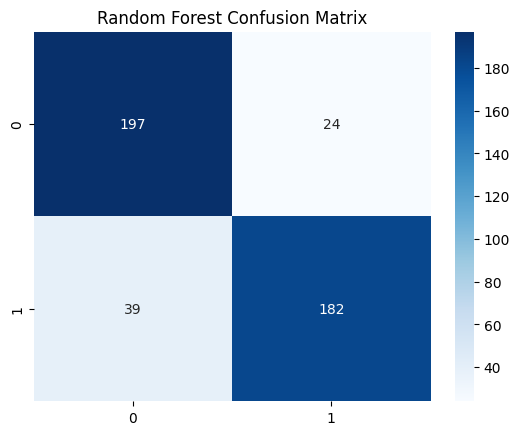

In [30]:
# Evaluate Models

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    print(f"\n{model_name} Performance:")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("ROC-AUC:", roc)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return f1  # Use F1 to select best model

rf_f1 = evaluate_model(rf_best, X_test, y_test, "Random Forest")





XGBoost Performance:
Accuracy: 0.8755656108597285
F1 Score: 0.8747152619589977
ROC-AUC: 0.9464998669150919
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88       221
         1.0       0.88      0.87      0.87       221

    accuracy                           0.88       442
   macro avg       0.88      0.88      0.88       442
weighted avg       0.88      0.88      0.88       442



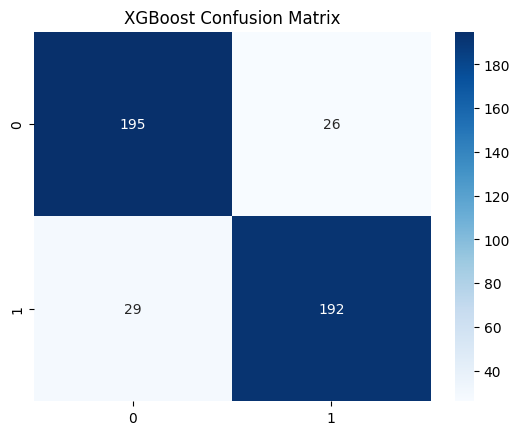

In [31]:
xgb_f1 = evaluate_model(xgb_best, X_test, y_test, "XGBoost")



Logistic Regression Performance:
Accuracy: 0.6493212669683258
F1 Score: 0.6501128668171557
ROC-AUC: 0.7017669580884912
              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65       221
         1.0       0.65      0.65      0.65       221

    accuracy                           0.65       442
   macro avg       0.65      0.65      0.65       442
weighted avg       0.65      0.65      0.65       442



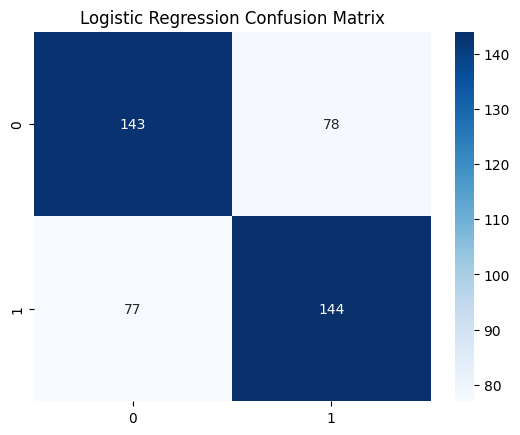

In [32]:
lr_f1 = evaluate_model(lr_best, X_test, y_test, "Logistic Regression")


# Model Performance Comparison

This visualization compares the baseline models (Random Forest, XGBoost, Logistic Regression) across key evaluation metrics:

- **Accuracy:** Overall correctness of predictions.
- **F1-Score:** Balance between precision and recall, useful for imbalanced classes.
- **ROC-AUC:** Measures the model's ability to distinguish between Correct and Incorrect responses.

> By plotting all three metrics side-by-side, we can quickly identify the best-performing model and understand relative strengths and weaknesses.  
> In this case, **XGBoost** slightly outperforms Random Forest, while Logistic Regression lags behind, especially in handling complex multimodal features.


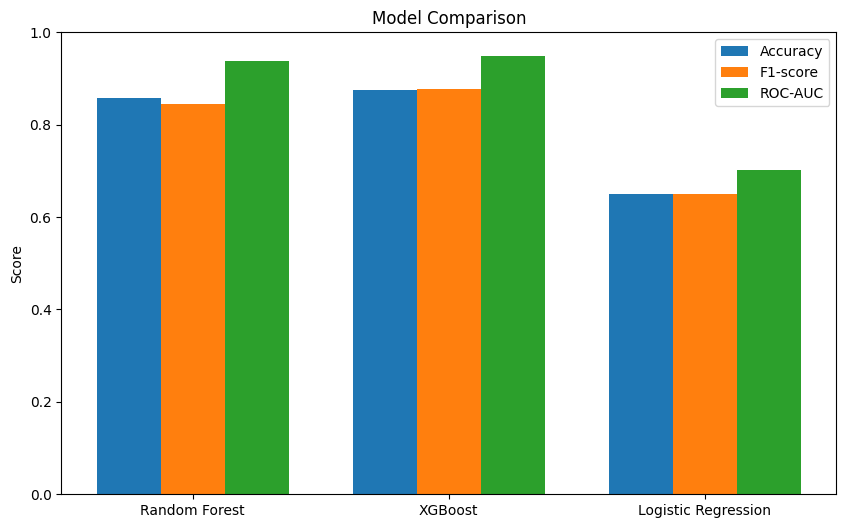

In [33]:
# Metricshhh
models = ['Random Forest', 'XGBoost', 'Logistic Regression']
accuracy = [0.8579, 0.8755, 0.6493]
f1 = [0.8448, 0.8764, 0.6501]
roc_auc = [0.9385, 0.9476, 0.7018]

x = range(len(models))

plt.figure(figsize=(10,6))
plt.bar(x, accuracy, width=0.25, label='Accuracy', align='center')
plt.bar([i + 0.25 for i in x], f1, width=0.25, label='F1-score', align='center')
plt.bar([i + 0.5 for i in x], roc_auc, width=0.25, label='ROC-AUC', align='center')

plt.xticks([i + 0.25 for i in x], models)
plt.ylabel("Score")
plt.title("Model Comparison")
plt.ylim(0,1)
plt.legend()
plt.show()


# Saving the Best Model

In this step, we:

1. **Compare all trained baseline models** using their F1-scores.
2. **Select the best-performing model** for deployment.  
   - F1-score is prioritized since it balances precision and recall, especially important for imbalanced datasets.
3. **Save the model and scaler** using `pickle` for future predictions or integration into applications.
4. **Print model information** for reference, including:
   - Name of the selected model
   - F1-score
   - Accuracy

> In this experiment, the model with the highest F1-score is saved, ensuring reliable performance on unseen participant responses.


In [34]:
# Step Save Best Model and Print Info

# Collect models, their F1 scores, and accuracy
models_metrics = [
    ('Random Forest', rf_best, rf_f1, accuracy_score(y_test, rf_best.predict(X_test))),
    ('XGBoost', xgb_best, xgb_f1, accuracy_score(y_test, xgb_best.predict(X_test))),
    ('Logistic Regression', lr_best, lr_f1, accuracy_score(y_test, lr_best.predict(X_test)))
]

# Select the best model based on F1 score
best_name, best_model, best_f1, best_acc = max(models_metrics, key=lambda x: x[2])

# Save the best model
with open('xg_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Print which model was saved and its performance
print(f" Best model saved: {best_name}")
print(f"F1 Score: {best_f1:.4f}")
print(f"Accuracy: {best_acc:.4f}")



 Best model saved: XGBoost
F1 Score: 0.8747
Accuracy: 0.8756


# Testing Prediction on a Random Sample

Here we demonstrate how the **saved best model** can predict the result for a **single random trial**:

1. **Select a random sample** from the dataset.
2. **Ensure the sample has the same features** used for training.
3. **Scale the sample** using the previously fitted `StandardScaler`.
4. **Predict** using the best model saved in the previous step.
5. **Compare prediction with actual label** to quickly validate model behavior.

> This step shows the model's ability to generalize and correctly classify unseen participant responses for mental rotation tasks.


In [35]:
sample_idx = random.choice(df.index)
sample_df = df.loc[sample_idx, X.columns].to_frame().T  # Convert to DataFrame with same column names

# Scale the sample
sample_scaled = scaler.transform(sample_df)

# Predict
pred = best_model.predict(sample_scaled)

print(f"\nRandom sample index: {sample_idx}, Predicted Result: {pred[0]}, Actual Result: {df.loc[sample_idx, 'Result']}")



Random sample index: 396, Predicted Result: 1, Actual Result: 1.0


# Feature Importance using SHAP

Here we analyze **which features contributed most** to the model's predictions:

1. Convert the **test set** back to a DataFrame with original feature names.
2. Initialize a **SHAP explainer** for the trained `best_model` (Tree-based model like XGBoost or Random Forest).
3. Compute **SHAP values** to measure each feature's contribution to predictions.
4. Visualize a **summary bar plot**:
   - Shows **global feature importance** across all test samples.
   - Helps identify which EEG, Eye, GSR, or Facial features most influence correctness prediction.

> This step provides interpretability, ensuring the model's decisions align with expected physiological and behavioral patterns in mental rotation tasks.


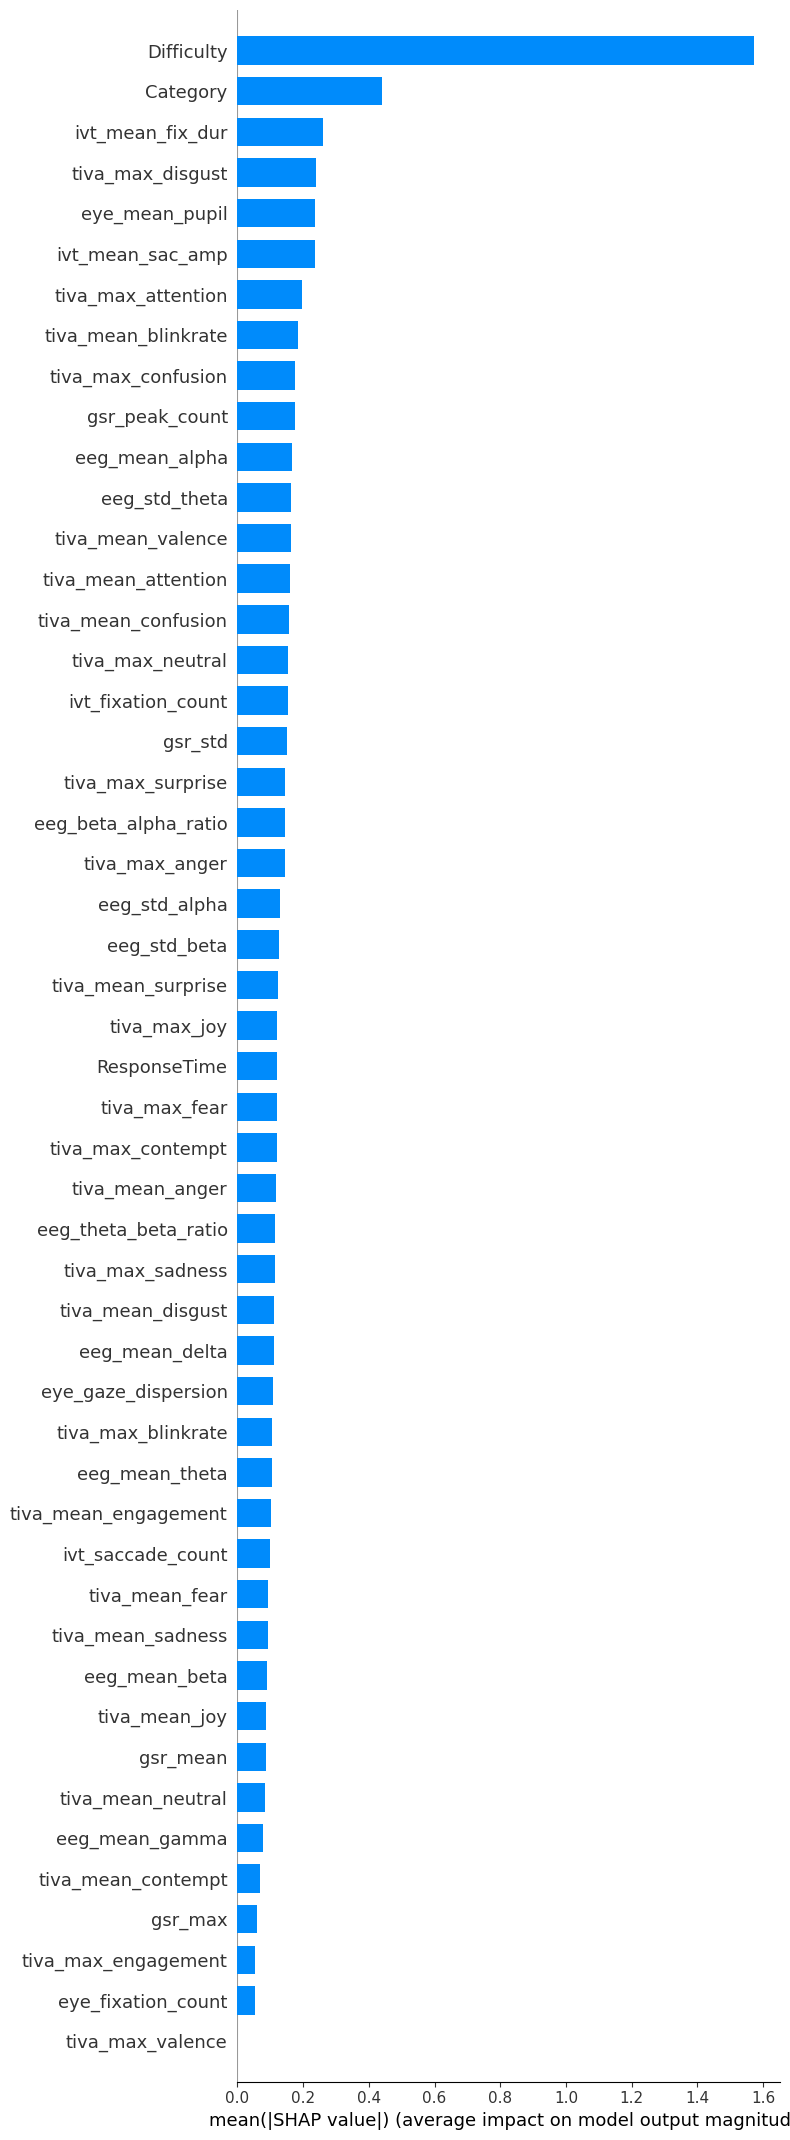

In [ ]:

X_test_df = pd.DataFrame(X_test, columns=X.columns)  # X.columns are your original feature names

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_df)

# Summary plot (bar chart) showing all features
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=X_test_df.shape[1])



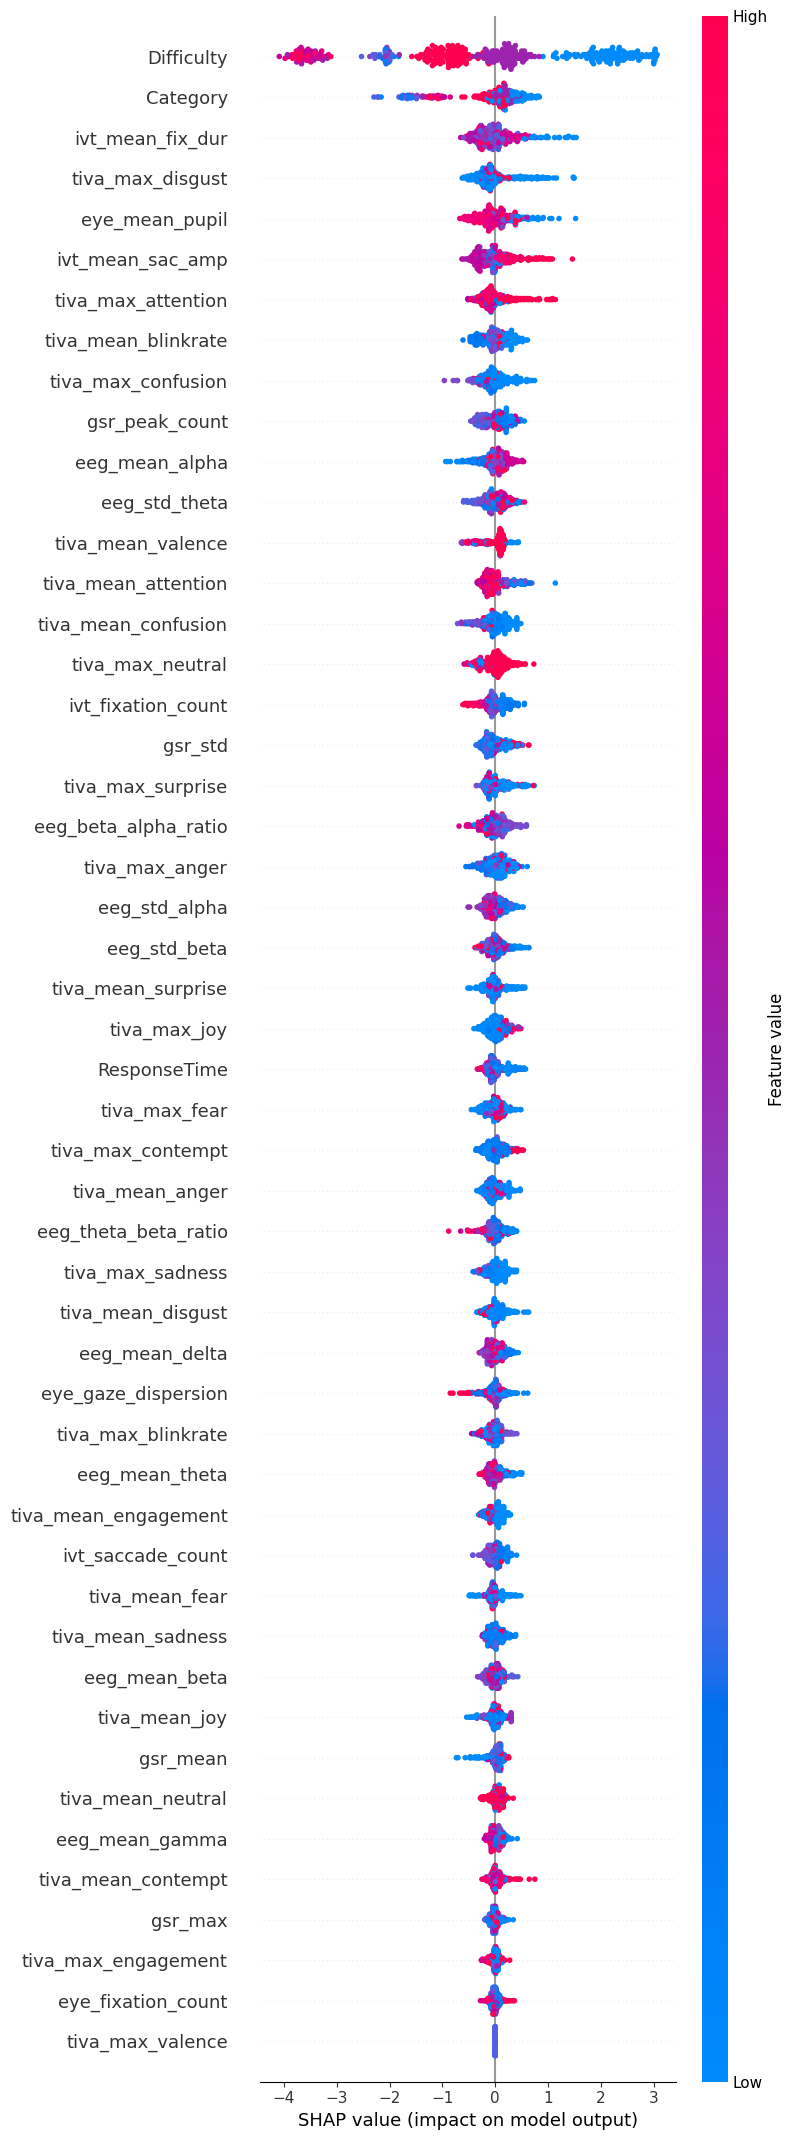

In [ ]:
# Detailed beeswarm plot showing all features
shap.summary_plot(shap_values, X_test_df, max_display=X_test_df.shape[1])

# Feature Explanation using LIME

This section explains **why the model predicted a certain outcome for a single test sample** using LIME:

1. **Prepare Data**:
   - Ensure `X_train` and `X_test` are DataFrames with correct feature names.
   - Randomly select a single sample from `X_test` for local explanation.

2. **Initialize LIME Explainer**:
   - `LimeTabularExplainer` uses training data to simulate local perturbations.
   - Mode set to `classification` with class labels `Incorrect` and `Correct`.

3. **Explain Sample Prediction**:
   - `explain_instance` generates feature contributions for that specific sample.
   - Converts explanation to a DataFrame for easier handling.

4. **Feature Processing**:
   - Compute **absolute contribution** to identify strongest features.
   - Select **top 20 features** for visualization.
   - Clean feature names by removing LIME-specific threshold artifacts.

5. **Interpretation & Visualization**:
   - Print top features with their contribution values.
   - Plot horizontal bar chart:
     - **Green bars** → positive contribution (towards correct prediction)
     - **Red bars** → negative contribution (towards incorrect prediction)
   - Helps understand **which features influenced the prediction the most** for that sample.



LIME Top 20 Major Features for sample index 75:
Feature: -0.34 < ivt_mean_sac_amp, Contribution: -0.0923
Feature: -1.05 < Difficulty, Contribution: 0.0916
Feature: tiva_max_disgust, Contribution: 0.0781
Feature: 0.33 < eye_mean_pupil, Contribution: -0.0545
Feature: -0.81 < tiva_mean_blinkrate, Contribution: -0.0522
Feature: 0.23 < tiva_mean_attention, Contribution: -0.0454
Feature: eye_gaze_dispersion, Contribution: 0.0438
Feature: eeg_std_alpha, Contribution: -0.0435
Feature: -0.10 < Category, Contribution: -0.0398
Feature: eeg_std_theta, Contribution: 0.0371
Feature: ivt_mean_fix_dur, Contribution: 0.0355
Feature: -0.23 < ivt_fixation_count, Contribution: -0.0352
Feature: -0.04 < tiva_mean_joy, Contribution: -0.0349
Feature: tiva_max_valence, Contribution: 0.0332
Feature: eeg_mean_gamma, Contribution: -0.0284
Feature: eeg_beta_alpha_ratio, Contribution: -0.0278
Feature: tiva_max_neutral, Contribution: -0.0258
Feature: tiva_mean_sadness, Contribution: 0.0257
Feature: tiva_max_surprise

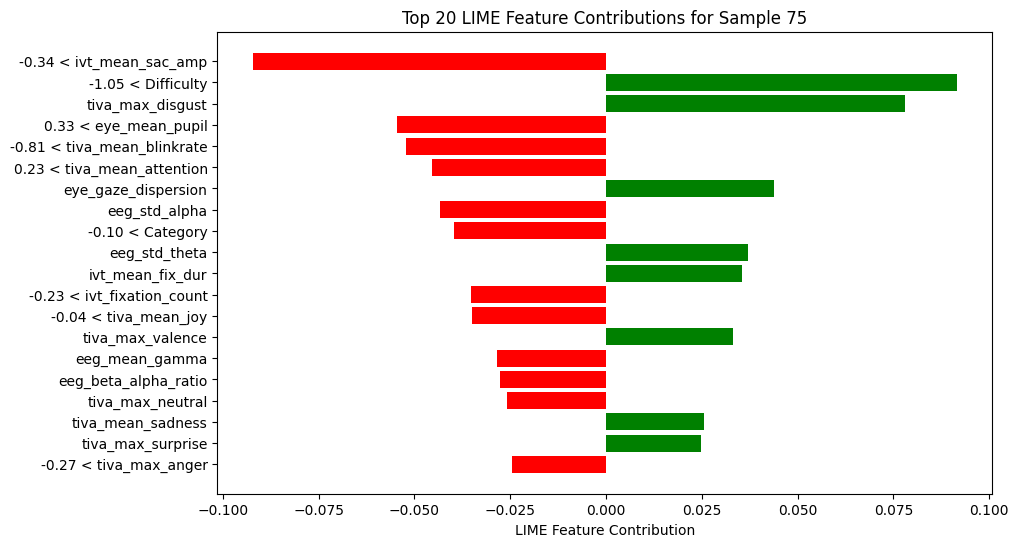

In [41]:
# Ensure X_train and X_test are DataFrames with correct column names
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=X.columns)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=X.columns)

# Pick a random sample from test set
sample_idx = np.random.randint(0, X_test.shape[0])
sample = X_test.iloc[sample_idx].values.reshape(1, -1)

# LIME Explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Incorrect', 'Correct'],
    mode='classification'
)

exp = explainer.explain_instance(sample[0], best_model.predict_proba, num_features=X_train.shape[1])

# Convert explanation to DataFrame
lime_df = pd.DataFrame(exp.as_list(), columns=['Feature', 'Contribution'])
lime_df['Abs_Contribution'] = lime_df['Contribution'].abs()

# Take top 20 features
top20_features = lime_df.sort_values(by='Abs_Contribution', ascending=False).head(20)

# Clean feature names (remove LIME range artifacts)
top20_features['Feature_clean'] = top20_features['Feature'].apply(lambda x: x.split(' <= ')[0].split(' > ')[0].split(' = ')[0].strip())

# Print top 20 features with contributions
print(f"LIME Top 20 Major Features for sample index {sample_idx}:")
for i, row in top20_features.iterrows():
    print(f"Feature: {row['Feature_clean']}, Contribution: {row['Contribution']:.4f}")

# Plot top 20 features
plt.figure(figsize=(10,6))
colors = ['green' if val>0 else 'red' for val in top20_features['Contribution']]
plt.barh(top20_features['Feature_clean'], top20_features['Contribution'], color=colors)
plt.xlabel("LIME Feature Contribution")
plt.title(f"Top 20 LIME Feature Contributions for Sample {sample_idx}")
plt.gca().invert_yaxis()  # Highest contribution at top
plt.show()
